In [13]:
import copy
import matplotlib.pyplot as plt
import numpy.random
from sklearn.linear_model import LinearRegression
import numpy as np
from typing import Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
import MyNeuralNetwork_New


### PyTorch network class for comparison with our network

In [621]:
# pyTorch neural network class

class myPytorchNetwork(nn.Module):
    def __init__(self, layers, activation):
        super(myPytorchNetwork, self).__init__()
        self.activation = activation
        self.fc_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])

    def forward(self, x):
        x = torch.flatten(x, 1)

        # TODO: I'm using relus everywhere for now, we need to change it to be adjustable
        for layer in self.fc_layers[:-1]:
            if self.activation == 'linear':
                x = layer(x)
            elif self.activation == 'relu':
                x = F.relu(layer(x))
            elif self.activation == 'sigmoid':
                x = torch.sigmoid(layer(x))
            elif self.activation == 'tanh':
                x = torch.tanh(layer(x))
            else:
                raise ValueError(f"Activation funtion {self.activation} is invalid")


        # No need for activation in the last layer
        return self.fc_layers[-1](x)


def train_torch_network(network: myPytorchNetwork, dataset, max_epochs, batch_size, train_ratio=0.8,
                        learning_rate=0.001, momentum=0.9, silent=False):
    loss_fn = torch.nn.MSELoss()
    # TODO: think of making the learning rate adaptive here, e.g. by using pytorch LR scheduler
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    split_index = int(dataset.shape[0] * train_ratio)
    train, validation = dataset[:split_index, :], torch.from_numpy(dataset[split_index:, :])

    best_validation_loss = float("inf")

    for epoch in range(max_epochs):
        np.random.shuffle(train)
        torch_train = torch.from_numpy(train)
        batch_start_idx = 0

        batches_loss = []
        # This way we skip last samples if there are less than batch_size of them
        while batch_start_idx + batch_size <= torch_train.shape[0]:
            optimizer.zero_grad()
            outputs = network(torch_train[batch_start_idx:batch_start_idx + batch_size, :-1])
            loss = loss_fn(torch.flatten(outputs), torch_train[batch_start_idx:batch_start_idx + batch_size, -1])
            batches_loss.append(loss.item())

            loss.backward()

            optimizer.step()
            batch_start_idx += batch_size

        # Now, check the loss on validation dataset
        validation_output = torch.flatten(network(validation[:, :-1]))
        validation_loss = loss_fn(validation_output, validation[:, -1])

        best_validation_loss = validation_loss

        if not silent:
            print(
                f"Epoch: {epoch}. \nLoss on training: {np.mean(batches_loss)} \nLoss on validation: {validation_loss} \n##########")


### Helper functions to run each model multiple times and gathering statistics

In [626]:
def run_my_neural_network(network_parameters, train_dataset, test_inputs) -> np.array:
    """
    Train our neural network and predict data from test_inputs
    """
    network = MyNeuralNetwork_New.MyNeuralNetwork(*network_parameters)
    network.fit(train_dataset[:, :-1], train_dataset[:, [-1]], batch_size=10)
    prediction = network.predict(test_inputs)
    return prediction



def run_linear_regression(train_dataset, test_inputs) -> np.array:
    """
    Train a linear regression on train_inputs, and predict data for test_inputs
    """
    reg = LinearRegression().fit(train_dataset[:, :-1], train_dataset[:, -1])
    prediction = reg.predict(test_inputs)
    return prediction


def run_pytorch_network(network_parameters,  train_dataset, test_inputs) -> np.array:
    """
    Train a pytorch network and predict outputs for test_inputs
    """
    network = myPytorchNetwork(*network_parameters)
    train_torch_network(network, train_dataset, 60, 10, learning_rate=0.005, silent=True, momentum=0.9, train_ratio=0.98)
    prediction = network(torch.from_numpy(test_inputs)).detach().numpy().flatten()
    return prediction


def measure_model_error_multiple_times(model: Callable, dataset: np.array, train_ratio=0.85, num_runs=5, silent=False):
    """
    :param model: a callable that accepts train dataset, test inputs, and produces the prediction for test inputs
    :param dataset: dataset to train on of shape (n_samples, n_features), where the last column is the value to be predicted
    :param train_ratio: how much data to put into the training dataset
    :param num_runs: number of runs with reshuffled dataset
    :param silent: if true, not print any output
    :return: mean MSE through all the runs
    """
    split_index = int(dataset.shape[0] * train_ratio)
    best_mape = 0
    best_mse = float("inf")
    for _ in range(num_runs):
        np.random.shuffle(dataset)
        train = dataset[:split_index, :]
        test = dataset[split_index:, :]

        prediction = model(train, test[:, :-1]).flatten()
        expected = test[:, -1].flatten()
        mse = np.mean((prediction - expected) ** 2)
        mape = 100 * np.mean(np.abs((prediction - expected) / expected))
        if not silent:
            print(f"Model MSE on test: {mse}")

        if mse < best_mse:
            best_mse = mse
            best_mape = mape

    return best_mape, best_mse

In [5]:
# Load the data
turbine = np.genfromtxt("processed_datasets/turbine.csv", dtype=np.float32, delimiter=',', skip_header=1)
synthetic = np.genfromtxt("processed_datasets/synthetic.csv", dtype=np.float32, delimiter=',', skip_header=1)
boston = np.genfromtxt("processed_datasets/boston.csv", dtype=np.float32, delimiter=',', skip_header=1)
turbine_input, turbine_output = turbine[:, :4], turbine[:, 4]

#### Just trying multiple times with different parameters to make sure that everything works

In [6]:
# Trying a couple of times with different splits into training and test data for a better understanging
measure_model_error_multiple_times(run_linear_regression, turbine)

Model MSE on test: 0.0012095796409994364
Model MSE on test: 0.000981383491307497
Model MSE on test: 0.0013646455481648445
Model MSE on test: 0.0010890918783843517
Model MSE on test: 0.001043768017552793


(10.976512730121613, 0.0009813835)

In [7]:
# Now trying, maybe applying some functions to features can make the situation better. There is no obvious relation here, but after trying, we found this gives better results (not always, but mostly better)

modified_turbine = turbine.copy()
modified_turbine[:, 1] = modified_turbine[:, 1] ** 2
modified_turbine[:, 0] = modified_turbine[:, 0] ** 2
measure_model_error_multiple_times(run_linear_regression, modified_turbine)

Model MSE on test: 0.0008923572604544461
Model MSE on test: 0.0009190035052597523
Model MSE on test: 0.0009788117604330182
Model MSE on test: 0.0010272865183651447
Model MSE on test: 0.001111943507567048


(7.424391061067581, 0.00089235726)

In [8]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[9, 5, 1], 'tanh'], *args), synthetic, num_runs=2)

Model MSE on test: 0.000930356967728585
Model MSE on test: 0.0012090656673535705


(6.523289531469345, 0.00093035697)

In [9]:
measure_model_error_multiple_times(lambda *args: run_my_neural_network([[9, 5, 1], 50, 0.01, 0.9, "tanh", 0.2], *args), synthetic, num_runs=5)

Model MSE on test: 0.0012535483164615015
Model MSE on test: 0.0014394176629208295
Model MSE on test: 0.0011799797925153741
Model MSE on test: 0.0010472831130765637
Model MSE on test: 0.0044513605004694885


(6.97588435266997, 0.0010472831130765637)

## Part 3.1

In [619]:
test_parameters = [
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "relu"],
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "sigmoid"],
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "tanh"],
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "linear"],
    # ["turbine", 6, [4, 5, 8, 10, 6, 1], 60, 0.001, 0.9, "tanh"],
    # ["turbine", 2, [4, 1], 60, 0.01, 0.7, "relu"],
    # ["turbine", 2, [4, 1], 60, 0.01, 0.7, "tanh"],
    # ["turbine", 4, [4, 5, 8, 1], 100, 0.001, 0.2, "tanh"],
    # ["turbine", 4, [4, 5, 8, 1], 60, 0.01, 0.2, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "relu"],
    # ["synthetic", 2, [9, 1], 30, 0.01, 0.9, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 100, 0.001, 0.9, "relu"],
    # ["synthetic", 4, [9, 18, 16, 1], 30, 0.01, 0.9, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 50, 0.01, 0.2, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "sigmoid"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "tanh"],
    # ["synthetic", 2, [9, 1], 30, 0.01, 0.9, "tanh"],
    # ["synthetic", 6, [9, 8, 6, 5, 5, 1], 30, 0.01, 0.4, "tanh"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "linear"],
    # ["boston", 4, [13, 8, 6, 1], 50, 0.001, 0.9, "relu"],
    # ["boston", 4, [13, 8, 6, 1], 50, 0.01, 0.9, "linear"],
    # ["boston", 4, [13, 8, 6, 1], 90, 0.001, 0.7, "relu"],
    # ["boston", 4, [13, 8, 6, 1], 70, 0.001, 0.9, "sigmoid"],
    ["boston", 4, [13, 18, 16, 1], 50, 0.01, 0.9, "tanh"],
    # ["boston", 4, [13, 8, 6, 1], 150, 0.001, 0.9, "tanh"],
    # ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 70, 0.01, 0.9, "tanh"],
    # ["boston", 7, [13, 12, 12, 13, 10, 9, 1], 80, 0.001, 0.9, "tanh"],
    # ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 70, 0.001, 0.2, "tanh"],
    # ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 70, 0.001, 0, "tanh"],
]

np.random.seed(10)

# The generated output here can be just copied directly to LaTeX table
for parameters in test_parameters:
    dataset, n_layers, layers, epochs, lr, momentum, activation = parameters
    mape, mse = measure_model_error_multiple_times(lambda *args: run_my_neural_network([layers, epochs, lr, momentum, activation, 0.2], *args), eval(dataset), num_runs=8, silent=True)
    print(" & ".join(map(str, parameters)) + " & {:.1f} & {:.3f} \\\\\n\\hline".format(mape, mse))

boston & 4 & [13, 18, 16, 1] & 50 & 0.01 & 0.9 & tanh & 13.7 & 0.004 \\
\hline


#### Generating plots for 3.1

In [507]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

def run_and_plot_for_dataset(network_parameters, dataset, train_ratio, name_on_plots):
    network = MyNeuralNetwork_New.MyNeuralNetwork(*network_parameters)
    # Train on part of data and scatter predictions
    split_index = int(train_ratio * dataset.shape[0])
    network.fit(dataset[:split_index, :-1], dataset[:split_index, -1], batch_size=1)
    predictions = network.predict(dataset[split_index:, :-1])

    loss = network.loss_epochs()
    loss_train = loss[:, 0]
    loss_val = loss[:, 1]

    plt.plot(range(1, network_parameters[1] + 1), loss_train, color='blue')
    plt.plot(range(1, network_parameters[1] + 1), loss_val, color='red')
    plt.title(f"Loss evolution for {name_on_plots} dataset")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend(["Training", "Validation"])
    plt.show()

    return dataset[split_index:, -1], predictions

In [557]:
def scatter_for_network(real, predictions, name):
    plt.scatter(real, predictions)
    plt.xlabel("Predictions")
    plt.ylabel("Real")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(f"Predicted vs real values for {name} dataset")

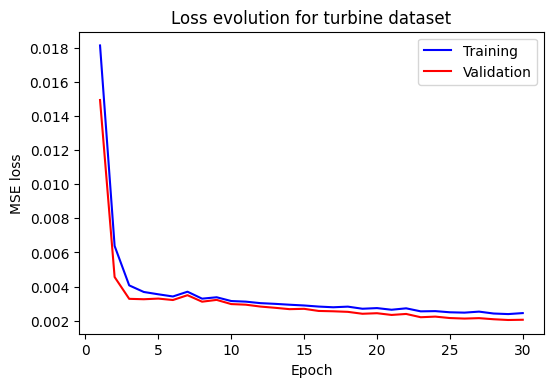

In [366]:
real, pred = run_and_plot_for_dataset([[4, 5, 1], 30, 0.01, 0.9, "tanh", 0.2], turbine, 0.85, "turbine")

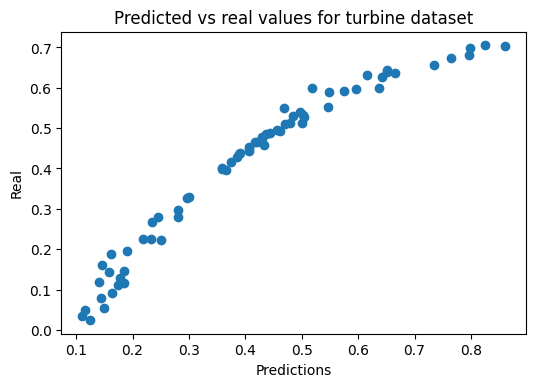

In [367]:
scatter_for_network(real, pred, "turbine")

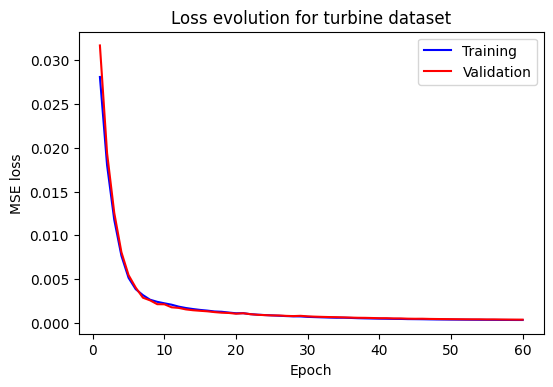

In [376]:
real, pred = run_and_plot_for_dataset([[4, 5, 8, 1], 60, 0.01, 0.2, "relu", 0.2], turbine, 0.85, "turbine")

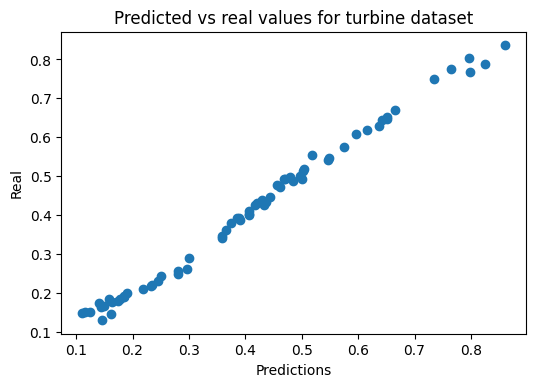

In [379]:
scatter_for_network(real, pred, "turbine")

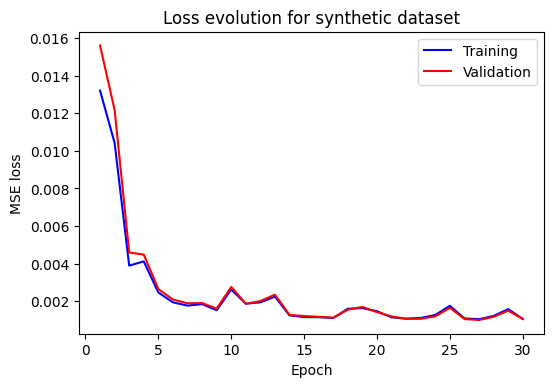

In [456]:
real, pred = run_and_plot_for_dataset([[9, 8, 6, 1], 30, 0.01, 0.9, "relu", 0.2], synthetic, 0.8, "synthetic")

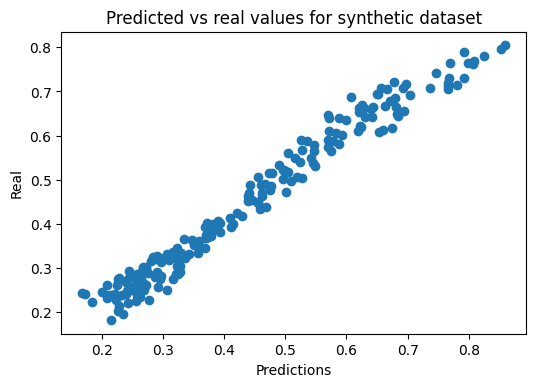

In [433]:
scatter_for_network(real, pred, "synthetic")

In [540]:
import importlib
importlib.reload(MyNeuralNetwork_New)

<module 'MyNeuralNetwork_New' from '/home/mrs/URV/NEC/HW1/MyNeuralNetwork_New.py'>

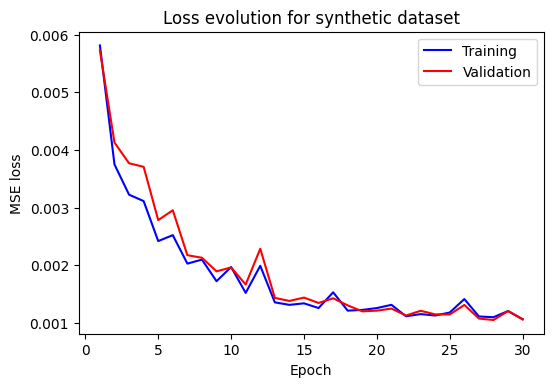

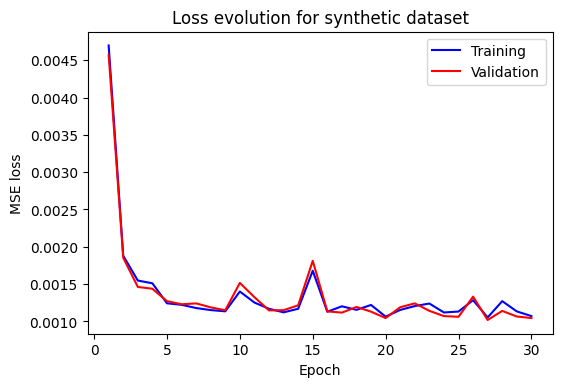

In [432]:
real, pred = run_and_plot_for_dataset([[9, 1], 30, 0.01, 0.9, "tanh", 0.2], synthetic, 0.8, "synthetic")

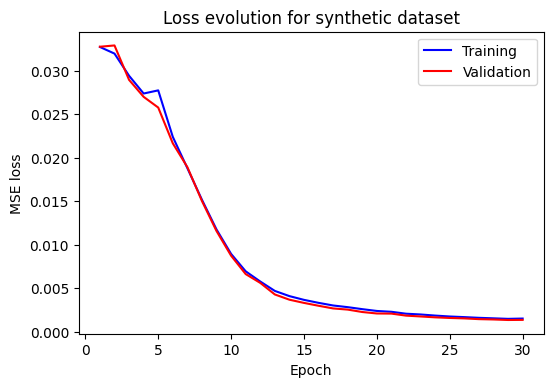

In [573]:
real, pred = run_and_plot_for_dataset([[9, 8, 6, 1], 30, 0.01, 0.9, "sigmoid", 0.2], synthetic, 0.8, "synthetic")

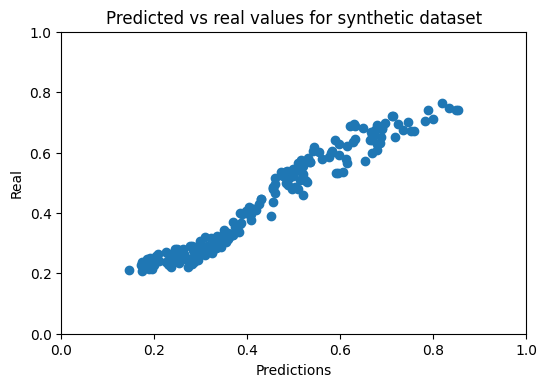

In [574]:
scatter_for_network(real, pred, "synthetic")

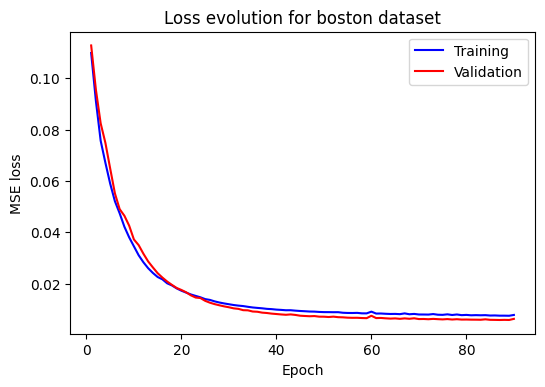

In [548]:
real, pred = run_and_plot_for_dataset([[13, 8, 6, 1], 90, 0.001, 0.7, "relu", 0.2], boston, 0.8, "boston")

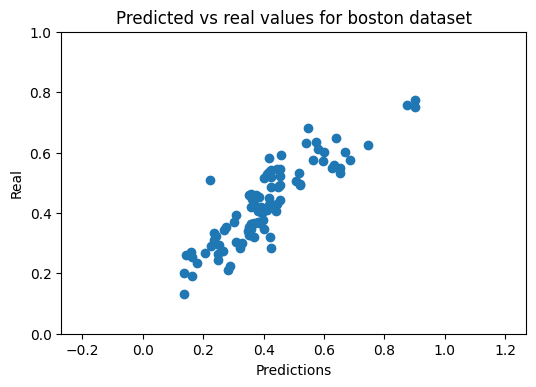

In [549]:
scatter_for_network(real, pred, "boston")

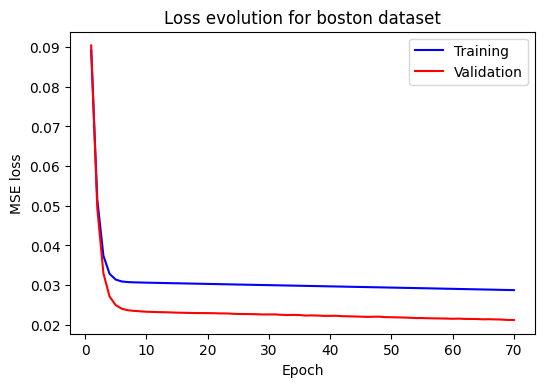

In [580]:
real, pred = run_and_plot_for_dataset([[13, 8, 6, 1], 70, 0.001, 0.9, "sigmoid", 0.2], boston, 0.8, "boston")

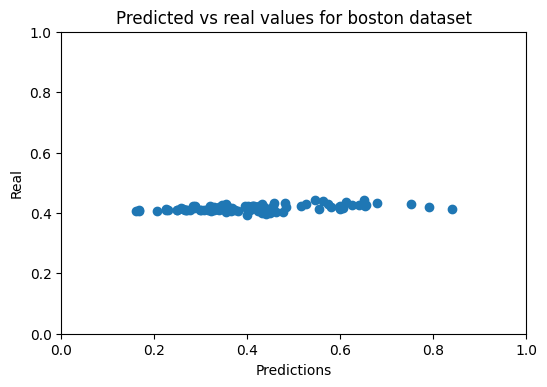

In [581]:
scatter_for_network(real, pred, "boston")

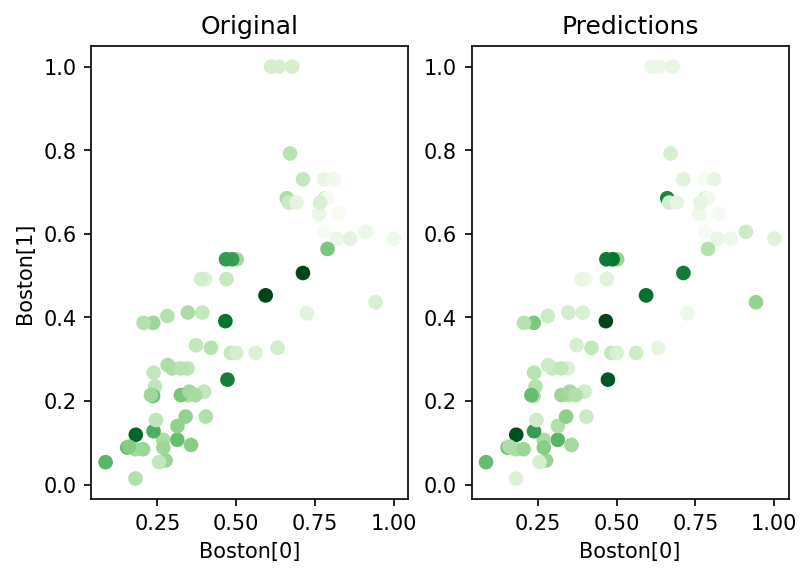

In [264]:
# A nice plot with colors representing predictions and needed value
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

n_epochs = 100
data = boston
network = MyNeuralNetwork_New.MyNeuralNetwork([13, 8, 7, 1], n_epochs, 0.01, 0.9, "tanh", 0.2)
# Train on part of data and scatter predictions
split_index = int(0.85 * data.shape[0])
network.fit(data[:split_index, :-1], data[:split_index, -1], batch_size=10)
predictions = network.predict(data[split_index:, :-1])

plt.subplot(1, 2, 1)
plt.scatter(data[split_index:, 0], data[split_index:, 4], c=data[split_index:, -1], marker='o', cmap='Greens')
plt.xlabel("Boston[0]")
plt.ylabel("Boston[1]")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.xlabel("Boston[0]")
plt.title("Predictions")
plt.scatter(data[split_index:, 0], data[split_index:, 4], c=predictions, marker='o', cmap='Greens')



# Part 3.2

### I was playing much with parameters here and rerunning stuff for tables generation, so it's a mess here now. I was replacing function inputs for different datasets

In [627]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[13, 8, 6, 1], 'tanh'], *args), boston, num_runs=10)

Model MSE on test: 0.008350836113095284
Model MSE on test: 0.00937613844871521
Model MSE on test: 0.010955908335745335
Model MSE on test: 0.00878878589719534
Model MSE on test: 0.0053551085293293
Model MSE on test: 0.009949960745871067
Model MSE on test: 0.008617845363914967
Model MSE on test: 0.009797055274248123
Model MSE on test: 0.013490553013980389
Model MSE on test: 0.008899030275642872


(14.099152386188507, 0.0053551085)

In [631]:
measure_model_error_multiple_times(lambda *args: run_my_neural_network([[13, 12, 10, 13, 10, 9, 1], 70, 0.01, 0.9, 'tanh', 0.01], *args), boston, num_runs=10)


Model MSE on test: 0.005085053391377817
Model MSE on test: 0.004990552603076408
Model MSE on test: 0.005259931955619812
Model MSE on test: 0.002995543819013336
Model MSE on test: 0.004848696615304539
Model MSE on test: 0.0059983038126438125
Model MSE on test: 0.0028767228161912166
Model MSE on test: 0.008721555841372181
Model MSE on test: 0.008026765311330506
Model MSE on test: 0.008829840404423736


(12.9005697387969, 0.0028767228161912166)

In [673]:
measure_model_error_multiple_times(run_linear_regression, boston, num_runs=10)

Model MSE on test: 0.010275826789438725
Model MSE on test: 0.009059252217411995
Model MSE on test: 0.010363048873841763
Model MSE on test: 0.006425630301237106
Model MSE on test: 0.009259392507374287
Model MSE on test: 0.008090280927717686
Model MSE on test: 0.0056296358816325665
Model MSE on test: 0.008469571359455585
Model MSE on test: 0.008154272101819515
Model MSE on test: 0.008353237062692642


(18.34287941455841, 0.005629636)